https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
import torch
import torchvision
from torchvision import transforms

In [2]:
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(80),
                                 torchvision.transforms.RandomRotation(degrees=(-90,90),fill=(0,)),
                              torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(80),
                                 torchvision.transforms.RandomRotation(degrees=(-90,90),fill=(0,)),
                              torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 80, 80])

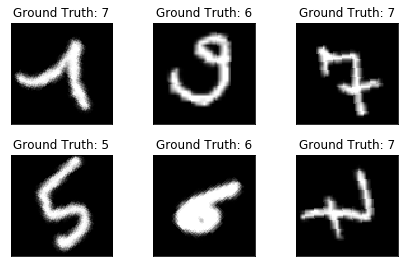

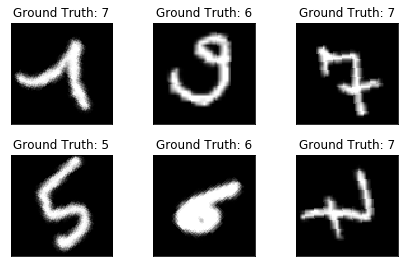

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(92416, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        print("x1",x.shape)
        x = self.conv1(x)
        print("x2",x.shape)
        x = F.relu(x)
        print("x3",x.shape)
        x = self.conv2(x)
        print("x4",x.shape)
        x = F.relu(x)
        print("x5",x.shape)
        x = F.max_pool2d(x, 2)
        print("x6",x.shape)
        x = self.dropout1(x)
        print("x7",x.shape)
        x = torch.flatten(x, 1)
        print("x8",x.shape)
        x = self.fc1(x)
        print("x9",x.shape)
        x = F.relu(x)
        print("x10",x.shape)
        x = self.dropout2(x)
        print("x11",x.shape)
        x = self.fc2(x)
        print("x12",x.shape)
        output = F.log_softmax(x, dim=1)
        print("output",x.shape)
        return output

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './model_data_test/model.pth')
            torch.save(optimizer.state_dict(), './model_data_test/optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
# for epoch in range(1, n_epochs + 1):
#     train(epoch)
#     test()

In [14]:
with torch.no_grad():
    output = network(example_data)

x1 torch.Size([1000, 1, 80, 80])
x2 torch.Size([1000, 32, 78, 78])
x3 torch.Size([1000, 32, 78, 78])
x4 torch.Size([1000, 64, 76, 76])
x5 torch.Size([1000, 64, 76, 76])
x6 torch.Size([1000, 64, 38, 38])
x7 torch.Size([1000, 64, 38, 38])
x8 torch.Size([1000, 92416])
x9 torch.Size([1000, 128])
x10 torch.Size([1000, 128])
x11 torch.Size([1000, 128])
x12 torch.Size([1000, 10])
output torch.Size([1000, 10])


In [15]:
output.shape

torch.Size([1000, 10])

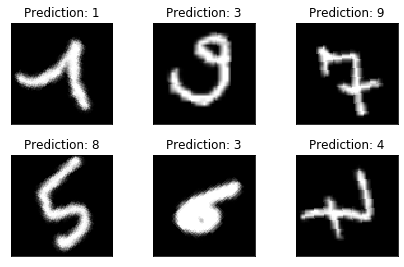

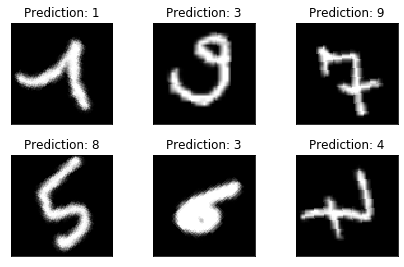

In [16]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [17]:
import argparse
from localization import *
from operator_classification import *
import numpy as np
from PIL import Image
import scipy.misc

In [18]:
def test_pred():

    arrow_locations = tip_tracking()
    cap = cv2.VideoCapture('robot_parcours_1.avi')
    t = 0
    eqn = ""
    digit_or_op = True
    while(cap.isOpened()):
        ret, _frame = cap.read()
        if ret==False: #if video is over
            break
        if t==0: #save the first frame
            first_frame = _frame
        arrow_loc = arrow_locations[t]
        x_min = max(arrow_loc[0]-40, 0)
        x_max = min(arrow_loc[0]+40, first_frame.shape[0])
        y_min = max(arrow_loc[1]-40,0)
        y_max = min(arrow_loc[1]+40, first_frame.shape[1])
        img = first_frame[x_min:x_max,y_min:y_max]
        model = Net()
        #load trained CNN model
        model.load_state_dict(torch.load("./model_data_test/model.pth"))
        model.eval()
        img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gg = np.expand_dims(img_g,axis=2)
        p = test_predict(model,img_gg)
        print(p)
        t+=1
    print(t)
    pass

In [19]:
trans = transforms.Compose([            #[1]
    transforms.ToTensor()])

In [20]:
def test_predict (model,img):
    img_t = trans(img)
    batch_t = torch.unsqueeze(img_t, 0)
    output = model(batch_t)
    pred = output.data.max(1, keepdim=True)[1].item()
    return pred

In [21]:
test_pred()

x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 128])
x10 torch.Size([1, 128])
x11 torch.Size([1, 128])
x12 torch.Size([1, 10])
output torch.Size([1, 10])
3
x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 128])
x10 torch.Size([1, 128])
x11 torch.Size([1, 128])
x12 torch.Size([1, 10])
output torch.Size([1, 10])
3
x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 12

x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 128])
x10 torch.Size([1, 128])
x11 torch.Size([1, 128])
x12 torch.Size([1, 10])
output torch.Size([1, 10])
3
x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 128])
x10 torch.Size([1, 128])
x11 torch.Size([1, 128])
x12 torch.Size([1, 10])
output torch.Size([1, 10])
3
x1 torch.Size([1, 1, 80, 80])
x2 torch.Size([1, 32, 78, 78])
x3 torch.Size([1, 32, 78, 78])
x4 torch.Size([1, 64, 76, 76])
x5 torch.Size([1, 64, 76, 76])
x6 torch.Size([1, 64, 38, 38])
x7 torch.Size([1, 64, 38, 38])
x8 torch.Size([1, 92416])
x9 torch.Size([1, 12

RuntimeError: size mismatch, m1: [1 x 75392], m2: [92416 x 128] at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorMath.cpp:136